In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from functools import partial
import matplotlib

import set_rcParams

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [6]:
l0 = 0.99 * jnp.exp(1.j * jnp.pi / 4)
lambda_star = 0.99 * jnp.exp(1.j * jnp.pi / 100)

def parametrize(v, type='exp'):
    if type == "real_imag":
        return v[0] + 1.j * v[1]
    elif type == 'exp':
        return jnp.tanh(v[0]) * jnp.exp(1.j * v[1])
    elif type == 'exp_exp':
        return jnp.tanh(v[0]) * jnp.exp(1.j * jnp.exp(v[1]))
    elif type == 'scaled_exp':
        nu = jnp.tanh(v[0])
        return nu * jnp.exp(1.j * (1 - nu**2) / nu / jnp.sqrt(1 + nu**2) * v[1])


def loss(v, param_type, mu=0, sigma=1, lower_bound=0.):
    lambda_est = parametrize(v, type=param_type)
    expectation_part =  mu**2 * jnp.abs(1 / (1 - lambda_est)  - 1 / (1 - lambda_star)) ** 2
    variance_part = sigma**2 * (1 / (1 - jnp.abs(lambda_est**2)) \
                                + 1 / (1 - jnp.abs(lambda_star)**2) \
                                - (2 / (1 - lambda_est * jnp.conj(lambda_star))).real)
    l = 0.5 * (expectation_part + variance_part)
    return jnp.clip(l, lower_bound, None)

@partial(jax.jit, static_argnums=(2, 3))
def step(lambda_est, opt_state, opt, param_type):
    l, grad = jax.value_and_grad(loss)(lambda_est, param_type)
    updates, opt_state = opt.update(grad, opt_state)
    return l, optax.apply_updates(lambda_est, updates)

def train(lambda_0, param_type="exp_exp", lr=1e-3, num_steps=100000, opt="adam"):
    opt = getattr(optax, opt)(lr)
    opt_state = opt.init(lambda_0)

    lambda_est = lambda_0
    losses, lambdas = [], []
    for i in range(num_steps):
        l, lambda_est = step(lambda_est, opt_state, opt, param_type)
        losses.append(l)
        lambdas.append(lambda_est)
    return losses, jnp.stack(lambdas), jax.vmap(lambda x: parametrize(x, type=param_type))(jnp.stack(lambdas))

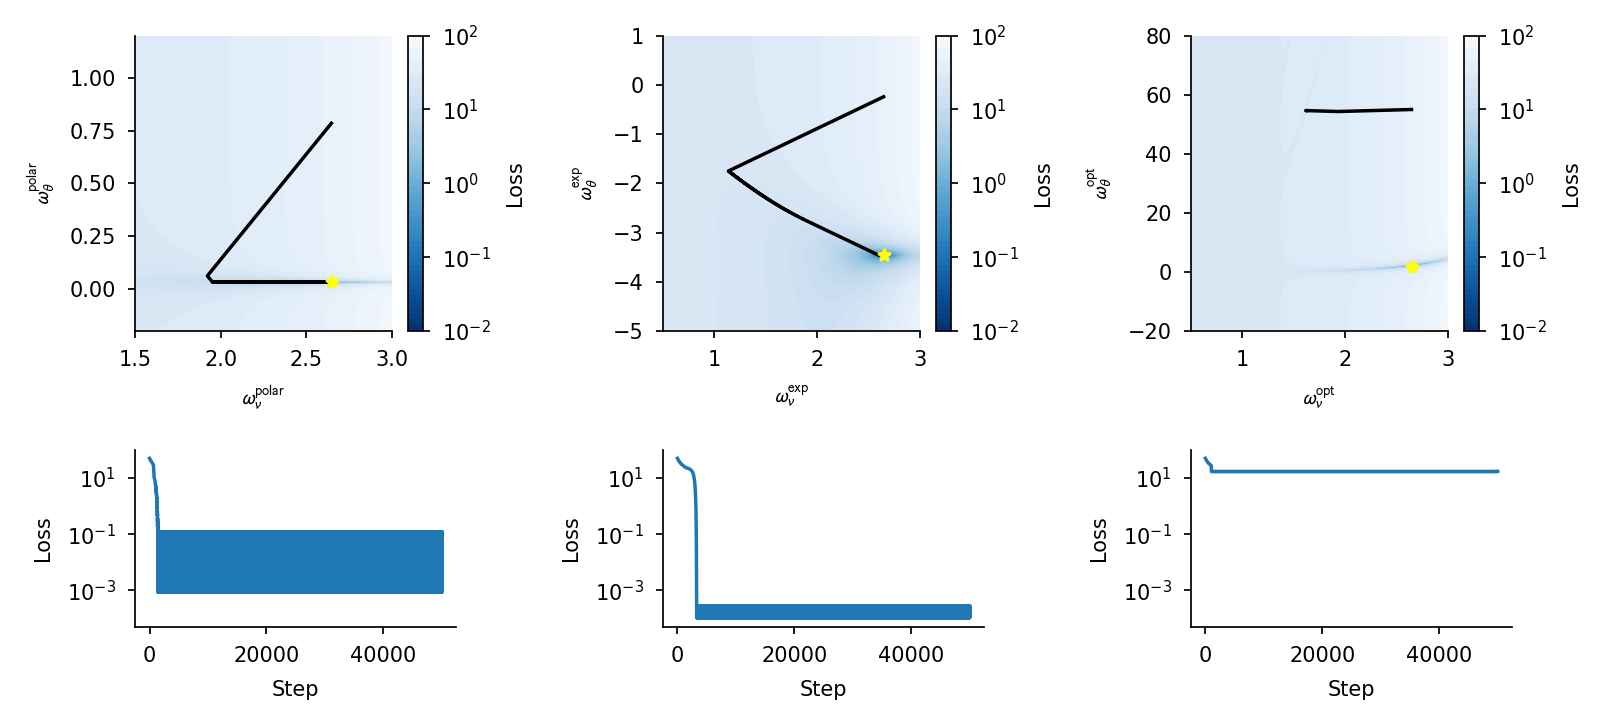

In [16]:
fig, ax = plt.subplots(2, 3, figsize=(6.5, 3), gridspec_kw={"height_ratios": [1, 0.6]})

param = "exp"
lambda_est = jnp.array([jnp.arctanh(jnp.abs(l0)), jnp.angle(l0)])
losses, raw_lambdas, lambdas = train(lambda_est, param_type=param, opt="adam", num_steps=50000, lr=1e-3)

x = jnp.linspace(1.5, 3, 1000)
y = jnp.linspace(-0.2, 1.2, 1000)
X, Y = jnp.meshgrid(x, y)
Z = jax.vmap(lambda x, y: loss(jnp.array([x, y]), param_type=param))(X, Y)

lvls = jnp.logspace(-2,2, 50)

# star for lambda_star
ax[0, 0].scatter(jnp.arctanh(jnp.abs(lambda_star)), jnp.angle(lambda_star), marker='*', color='yellow', s=10, zorder=100)
c = ax[0, 0].contourf(X, Y, jnp.clip(Z, 1e-2, 1e2), levels=lvls, cmap="Blues_r", norm=matplotlib.colors.LogNorm(vmin=1e-2, vmax=1e2))
cbar = plt.colorbar(c, ticks=[0.01, 0.1, 1, 10, 100], label="Loss")

ax[0, 0].plot(raw_lambdas[:, 0], raw_lambdas[:, 1], color='black', alpha=1)
ax[0, 0].set_xlabel(r"$\omega_\nu^\mathrm{polar}$")
ax[0, 0].set_ylabel(r"$\omega_\theta^\mathrm{polar}$")

ax[1, 0].plot(losses)
ax[1, 0].set_yscale("log")
ax[1, 0].set_xlabel("Step")
ax[1, 0].set_ylabel("Loss")
ax[1, 0].set_ylim(5e-5, 100)
ax[1, 0].minorticks_off()


param = "scaled_exp"
lambda_est = jnp.array([jnp.arctanh(jnp.abs(l0)), jnp.angle(l0) / (1 - jnp.abs(l0)**2) * jnp.sqrt(1 + jnp.abs(l0)**2) * jnp.abs(l0)])
losses, raw_lambdas, lambdas = train(lambda_est, param_type=param, opt="adam", num_steps=50000, lr=1e-3)

x = jnp.linspace(0.5, 3, 1000)
y = jnp.linspace(-20, 80, 1000)
X, Y = jnp.meshgrid(x, y)
Z = jax.vmap(lambda x, y: loss(jnp.array([x, y]), param_type=param))(X, Y)

lvls = jnp.logspace(-2 ,2, 50)

# star for lambda_star
ax[0, 2].scatter(jnp.arctanh(jnp.abs(lambda_star)), jnp.angle(lambda_star) / (1 - jnp.abs(lambda_star)**2), marker='*', color='yellow', s=10, zorder=100)
c = ax[0, 2].contourf(X, Y, jnp.clip(Z, 1e-2, 1e2), levels=lvls, cmap="Blues_r", norm=matplotlib.colors.LogNorm(vmin=1e-2, vmax=1e2))
cbar = plt.colorbar(c, ticks=[0.01, 0.1, 1, 10, 100], label="Loss")

ax[0, 2].plot(raw_lambdas[:, 0], raw_lambdas[:, 1], color='black', alpha=1)
ax[0, 2].set_xlabel(r"$\omega_\nu^\mathrm{opt}$")
ax[0, 2].set_ylabel(r"$\omega_\theta^\mathrm{opt}$")

ax[1, 2].plot(losses)
ax[1, 2].set_yscale("log")
ax[1, 2].set_xlabel("Step")
ax[1, 2].set_ylabel("Loss")
ax[1, 2].set_ylim(5e-5, 100)
ax[1, 2].minorticks_off()



param = "exp_exp"
lambda_est = jnp.array([jnp.arctanh(jnp.abs(l0)), jnp.log(jnp.angle(l0))])
losses, raw_lambdas, lambdas = train(lambda_est, param_type=param, opt="adam", num_steps=50000, lr=1e-3)

x = jnp.linspace(0.5, 3, 1000)
y = jnp.linspace(-5., 1., 1000)
X, Y = jnp.meshgrid(x, y)
Z = jax.vmap(lambda x, y: loss(jnp.array([x, y]), param_type=param))(X, Y)

lvls = jnp.logspace(-2,2, 50)

# star for lambda_star
ax[0, 1].scatter(jnp.arctanh(jnp.abs(lambda_star)), jnp.log(jnp.angle(lambda_star)), marker='*', color='yellow', s=10, zorder=100)
c = ax[0, 1].contourf(X, Y, jnp.clip(Z, 1e-2, 1e2), levels=lvls, cmap="Blues_r", norm=matplotlib.colors.LogNorm(vmin=1e-2, vmax=1e2))
cbar = plt.colorbar(c, ticks=[0.01, 0.1, 1, 10, 100], label="Loss")

ax[0, 1].plot(raw_lambdas[:, 0], raw_lambdas[:, 1], color='black', alpha=1)
ax[0, 1].set_xlabel(r"$\omega_\nu^\mathrm{exp}$")
ax[0, 1].set_ylabel(r"$\omega_\theta^\mathrm{exp}$")

ax[1, 1].plot(losses)
ax[1, 1].set_yscale("log")
ax[1, 1].set_xlabel("Step")
ax[1, 1].set_ylabel("Loss")
ax[1, 1].set_ylim(5e-5, 100)
ax[1, 1].minorticks_off()



plt.tight_layout()